# 🏠 House Price Prediction with Multiple ML Models

This project predicts house prices using different machine learning models and compares their accuracy and training time.  
We'll use:
- **Python** for implementation
- **NumPy** & **Pandas** for data handling
- **Matplotlib** for visualization
- **Scikit Learn** for linear regression and decision trees
- **TensorFlow** for neural networks

## Goals:
1. Load and explore the dataset
2. Data visualization
3. Preprocess data (handle missing values, engineering, scaling, encoding)
4. Train multiple models
    - 4.1 Linear Regression
    - 4.2 Neural Networks
    - 4.3 Decision Trees
5. Compare accuracy & execution time
6. Visualize results

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

Libraries imported successfully!
TensorFlow version: 2.20.0


1. **Data Loading and Exploration**

In [5]:
# Load the datasets
try:
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')
    print("Data loaded successfully!")
    print(f"Training data shape: {train_data.shape}")
    print(f"Test data shape: {test_data.shape}")
except FileNotFoundError:
    print("Please make sure 'train.csv' and 'test.csv' are in your current directory")

# Display basic information about the dataset
print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)
print(train_data.head())
print(f"\nDataset Info:")
print(f"Number of features: {train_data.shape[1]-1}")
print(f"Number of training samples: {train_data.shape[0]}")
print(f"Target variable: SalePrice")

# Check for missing values
print("\nMissing values in training data:")
missing_values = train_data.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print(missing_values.head(10))

# Basic statistics of the target variable
print(f"\nTarget Variable (SalePrice) Statistics:")
print(train_data['SalePrice'].describe())

Data loaded successfully!
Training data shape: (1460, 81)
Test data shape: (1459, 80)

DATASET OVERVIEW
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN  

2. **Data Visualization**

Here is a short description for each of the four graphs:

**Distribution of SalePrice (top-left):**
Shows the raw distribution of house prices in the dataset. It’s often right-skewed, meaning there are many moderately priced homes and fewer very expensive ones.

**Log Distribution of SalePrice (top-right):**
Displays the distribution of the logarithm of house prices. This transformation reduces skewness, making the data closer to a normal distribution, which is useful for regression models.

**Top 20 Features with Missing Values (bottom-left):**
A bar chart highlighting which features have the most missing data. This helps identify columns that may require data cleaning, imputation, or removal.

**Top 10 Features Correlated with SalePrice (bottom-right):**
A bar chart of numerical features most strongly correlated with the target variable (SalePrice). This highlights which features are most predictive and useful for modeling.

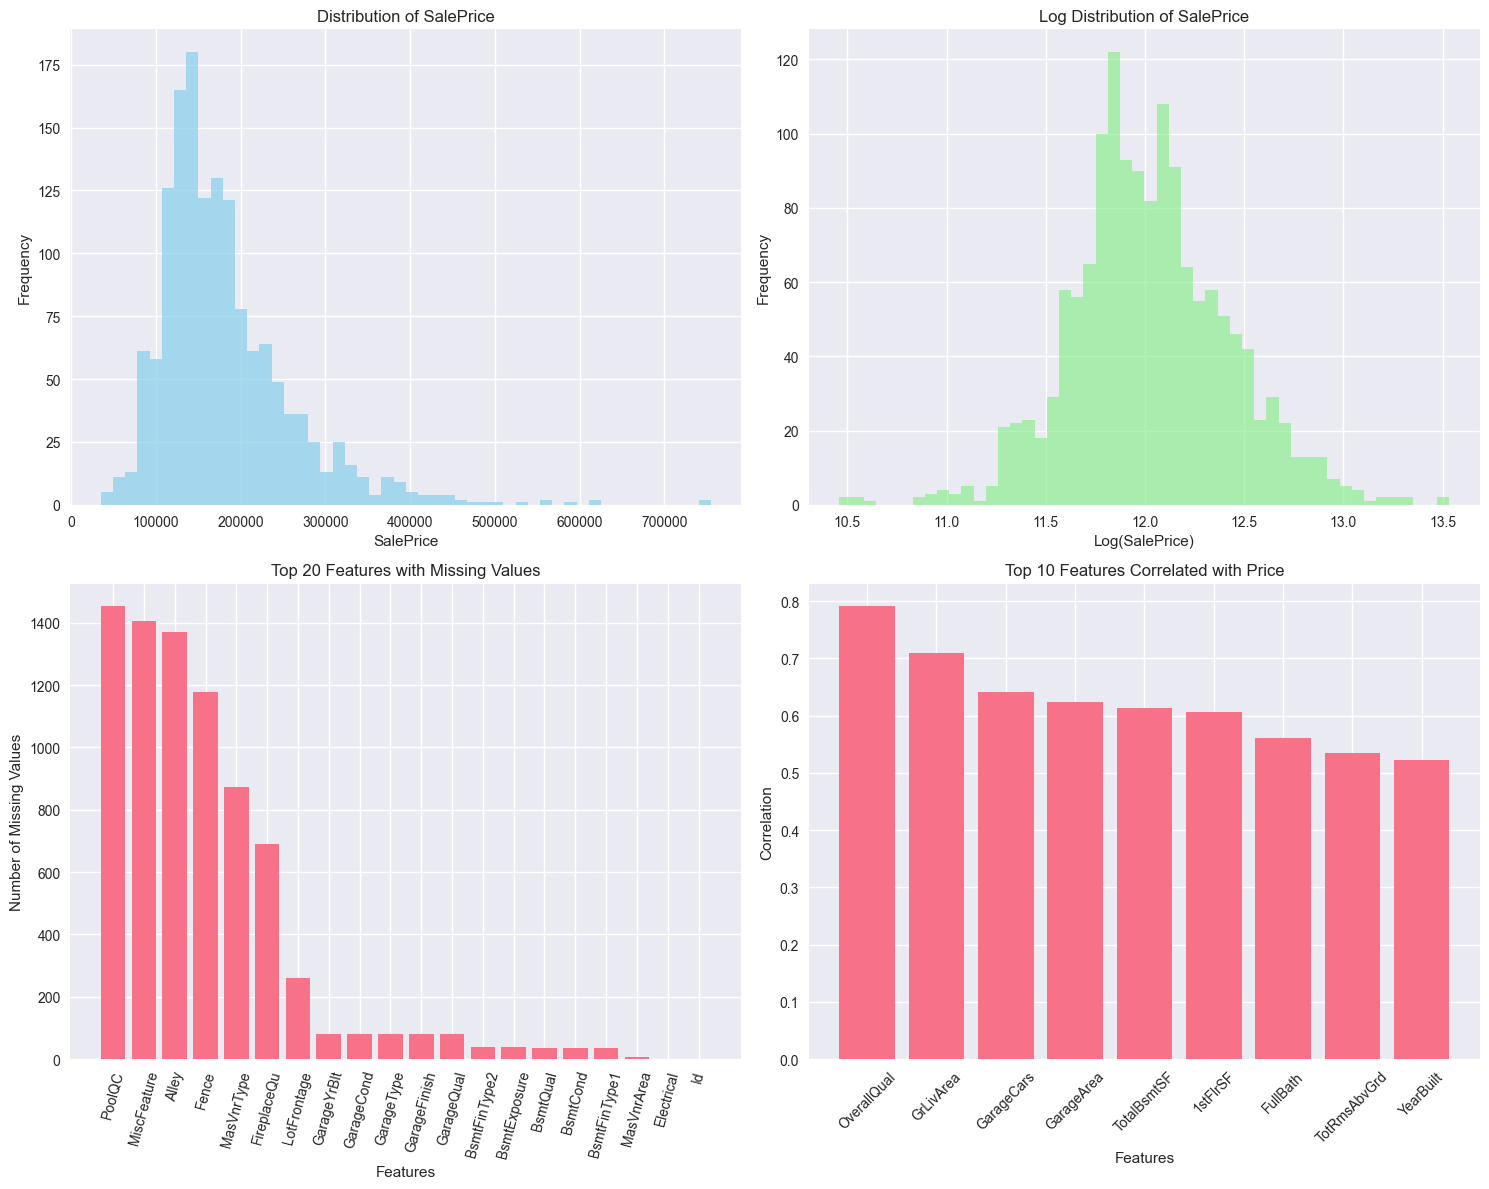

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

#Distribution of target variable
axes[0, 0].hist(train_data['SalePrice'], bins=50, alpha=0.7, color='skyBlue')
axes[0, 0].set_title('Distribution of SalePrice')
axes[0, 0].set_xlabel('SalePrice')
axes[0, 0].set_ylabel('Frequency')

# Log distribution of target variable
axes[0, 1].hist(np.log1p(train_data['SalePrice']), bins=50, alpha=0.7, color='lightgreen')
axes[0, 1].set_title('Log Distribution of SalePrice')
axes[0, 1].set_xlabel('Log(SalePrice)')
axes[0, 1].set_ylabel('Frequency')

# Missing values visualization
missing_data = train_data.isnull().sum().sort_values(ascending=False).head(20)
axes[1, 0].bar(missing_data.index, missing_data.values)
axes[1, 0].set_title('Top 20 Features with Missing Values')
axes[1, 0].set_xlabel('Features')
axes[1, 0].set_ylabel('Number of Missing Values')
axes[1, 0].tick_params(axis='x', rotation=75)

# Correlation with target variable (only for numerical features)
numerical_features = train_data.select_dtypes(include=[np.number]).columns
correlations = train_data[numerical_features].corr()['SalePrice'].sort_values(ascending=False)
top_corr = correlations.head(10)[1:]
axes[1,1].bar(top_corr.index, top_corr.values)
axes[1,1].set_title('Top 10 Features Correlated with Price')
axes[1,1].set_xlabel('Features')
axes[1,1].set_ylabel('Correlation')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

3. **Data Preprocessing and Cleaning**

In this step, we perform comprehensive preprocessing on both the training and test datasets to ensure consistency and improve model performance. The main steps are:  

1. **Combine Train and Test Data**
2. **Handle Missing Values**
3. **Feature Engineering**
   - **TotalSF**: Sum of basement and floor areas (overall square footage).  
   - **HouseAge**: Age of the property since construction.  
   - **RemodelAge**: Years since last remodel.  
   - **TotalBath**: Combined measure of all bathrooms (full, half, basement).  
   - **TotalPorchSF**: Total porch area across different porch types.  

4. **Encoding Categorical Features**
5. **Split Back into Train/Test**
6. **Prepare Features and Target Variable**
   - Defined `X` as features and `y` as the target (`SalePrice`).
7. **Train/Validation Split**  
   - Split training data into training and validation sets (80/20 split).
8. **Feature Scaling**  
   - Standardized numerical features using `StandardScaler` for better performance with models sensitive to feature magnitude.  

This pipeline ensures clean, consistent, and enriched data for training multiple models (Linear Regression, Decision Trees, Neural Networks).  


In [18]:
def preprocess_data(train_df, test_df):
    """Comprehensive data preprocessing function."""
    print("\n" + "="*50)
    print("DATA PREPROCESSING")
    print("="*50)

    # Combine train and test for consistent preprocessing
    train_len = len(train_df)
    combined_data = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)

    # Handle missing values
    print("\nHandling missing values...")

    # Categorical features - fill with 'None' or mode
    categorical_features = combined_data.select_dtypes(include=['object']).columns
    for feature in categorical_features:
        combined_data[feature].fillna('None', inplace=True)

    # Numerical features - fill with mean or median
    numerical_features = combined_data.select_dtypes(include=[np.number]).columns
    numerical_features = numerical_features.drop('SalePrice', errors='ignore')  # Exclude target variable if present

    for feature in numerical_features:
        combined_data[feature].fillna(combined_data[feature].median(), inplace=True)

    # Feature Engineering
    print("Engineering new features...")

    # Total area feature
    combined_data['TotalSF'] = combined_data['1stFlrSF'] + combined_data['2ndFlrSF'] + combined_data['TotalBsmtSF']

    # Age of house
    combined_data['HouseAge'] = combined_data['YrSold'] - combined_data['YearBuilt']
    combined_data['RemodelAge'] = combined_data['YrSold'] - combined_data['YearRemodAdd']

    # Bathroom features
    combined_data['TotalBath'] = combined_data['FullBath'] + combined_data['HalfBath']*0.5 + combined_data['BsmtFullBath'] + combined_data['BsmtHalfBath']*0.5

    # Porch area
    porch_features = ['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
    combined_data['TotalPorchSF'] = combined_data[porch_features].sum(axis=1)

    # Encode categorical features
    print("Encoding categorical features...")
    label_encoders = {}
    for feature in categorical_features:
        le = LabelEncoder()
        combined_data[feature] = le.fit_transform(combined_data[feature].astype(str))
        label_encoders[feature] = le
    
    # Split back into train and test sets
    processed_train = combined_data[:train_len].copy()
    processed_test = combined_data[train_len:].copy()

    # Remove Id column if it exists
    if 'Id' in processed_train.columns:
        processed_train.drop('Id', axis=1)
    if 'Id' in processed_test.columns:
        processed_test.drop('Id', axis=1)
    
    print("Data preprocessing completed successfully!")
    print(f"Processed training data shape: {processed_train.shape}")
    print(f"Processed test data shape: {processed_test.shape}")

    return processed_train, processed_test, label_encoders

# Apply preprocessing
processed_train, processed_test, encoders = preprocess_data(train_data, test_data)

# Prepare features and target variable
X = processed_train.drop('SalePrice', axis=1)
y = processed_train['SalePrice']

# Log transform the target variable for better model performance
y_log = np.log(y)

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

# Split the data
X_train, X_val, y_train_log, y_val_log = train_test_split(X, y_log, test_size=0.2, random_state=42)
y_train, y_val = np.exp(y_train_log), np.exp(y_val_log)  # Convert back to original scale for evaluation

print(f"\nTraining set: {X_train.shape[0]} samples, Validation set: {X_val.shape[0]} samples")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("\nFeature scaling completed!")



DATA PREPROCESSING

Handling missing values...
Engineering new features...
Encoding categorical features...
Data preprocessing completed successfully!
Processed training data shape: (1460, 86)
Processed test data shape: (1459, 86)

Feature matrix shape: (1460, 85)
Target variable shape: (1460,)

Training set: 1168 samples, Validation set: 292 samples

Feature scaling completed!


4. **Model Implementation**

When comparing models, we use the following metrics:  

1. **RMSE (Root Mean Squared Error)**
   - Measures the average magnitude of prediction errors (in the same units as the target).  
   - Penalizes large errors more strongly.  
   - **Lower RMSE = better model fit**.  

2. **MAE (Mean Absolute Error)**
   - Measures the average of absolute prediction errors.  
   - More robust to outliers compared to RMSE.  
   - **Lower MAE = better model performance**.  

3. **R² Score (Coefficient of Determination)**
   - Represents how much of the variance in the target variable is explained by the model.  
   - Ranges from **0 to 1** (sometimes negative if the model is worse than predicting the mean).  
   - **Closer to 1 = better explanatory power**.  

4. **Training Time**
   - Measures how long the model took to train.  
   - Important when comparing simple vs. complex models.  
   - **Faster training** is preferable for scalability, but sometimes slower models perform better.  

### How to Interpret Results
- **Low RMSE & MAE**: The model makes accurate predictions.  
- **High R²**: The model explains most of the variance in housing prices.  
- **Training Time Trade-off**: A slightly slower model may be acceptable if it achieves significantly better accuracy.  


In [19]:
results = {
    'Model': [],
    'RMSE': [],
    'MAE': [],
    'R2_Score': [],
    'Training_Time': []
}

def evaluate_model(model_name, y_true, y_pred, training_time):
    """Evaluate model performance"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    results['Model'].append(model_name)
    results['RMSE'].append(rmse)
    results['MAE'].append(mae)
    results['R2_Score'].append(r2)
    results['Training_Time'].append(training_time)

    print(f"\n{model_name} Results:")
    print(f"RMSE: {rmse:,.2f}") 
    print(f"MAE: {mae:,.2f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"Training Time: {training_time:.2f} seconds")

    return rmse, mae, r2



**4.1 Linear Regression Models**

In [22]:
print("\n -- Linear Regression Models -- ")

# Simple Linear Regression
start_time = time.time()
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train_log)
y_pred_log = lr_model.predict(X_val_scaled)
y_pred = np.exp(y_pred_log)  # Convert back to original scale
lr_time = time.time() - start_time
evaluate_model("Linear Regression", y_val, y_pred, lr_time)

# Ridge Regression (L2 Regularization)
start_time = time.time()
ridge_model = Ridge(alpha=100, random_state=42)
ridge_model.fit(X_train_scaled, y_train_log)
ridge_pred_log = ridge_model.predict(X_val_scaled)
ridge_pred = np.exp(ridge_pred_log)  # Convert back to original scale
ridge_time = time.time() - start_time
evaluate_model("Ridge Regression", y_val, ridge_pred, ridge_time)

# Lasso Regression (L1 Regularization)
start_time = time.time()
lasso_model = Lasso(alpha=0.01, random_state=42)
lasso_model.fit(X_train_scaled, y_train_log)
lasso_pred_log = lasso_model.predict(X_val_scaled)
lasso_pred = np.exp(lasso_pred_log)  # Convert back to original scale
lasso_time = time.time() - start_time
evaluate_model("Lasso Regression", y_val, lasso_pred, lasso_time)


 -- Linear Regression Models -- 

Linear Regression Results:
RMSE: 28,273.48
MAE: 18,382.70
R2 Score: 0.8958
Training Time: 0.01 seconds

Ridge Regression Results:
RMSE: 27,906.82
MAE: 18,037.29
R2 Score: 0.8985
Training Time: 0.05 seconds

Lasso Regression Results:
RMSE: 29,843.27
MAE: 18,694.02
R2 Score: 0.8839
Training Time: 0.02 seconds


(np.float64(29843.266490265538), 18694.022614944523, 0.8838875256733552)

**4.2 Neural Network**


 -- Neural Network -- 

Creating and training the neural network...

Neural Network Results:
RMSE: 829,484.70
MAE: 165,824.86
R2 Score: -88.7022
Training Time: 2.33 seconds


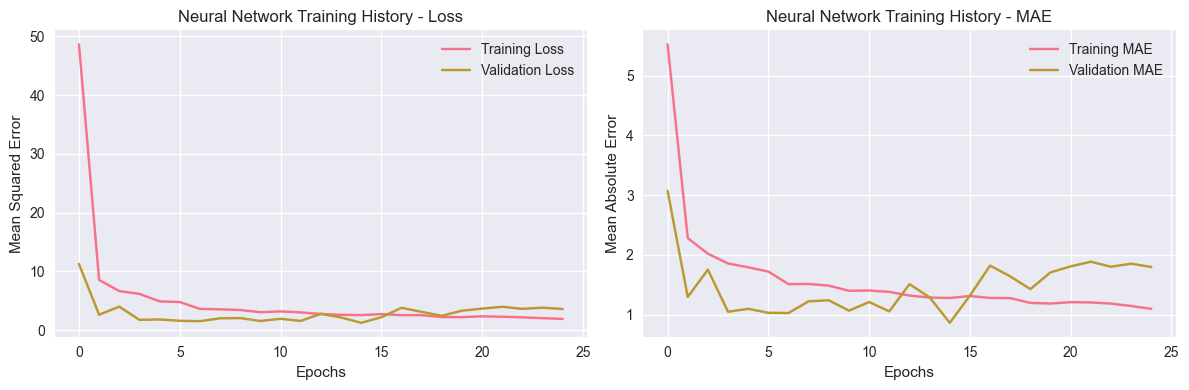

In [23]:
print("\n -- Neural Network -- ")

def create_neural_network(input_dim):
    model = keras.Sequential([
        layers.Dense(256, activation='relu', input_shape=(input_dim,)),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)  # Output layer for regression
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

print("\nCreating and training the neural network...")
start_time = time.time()

# Create the model and train it
nn_model = create_neural_network(X_train_scaled.shape[1])

# Early stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = nn_model.fit(X_train_scaled, y_train_log, 
                       validation_data=(X_val_scaled, y_val_log),
                       epochs=100, 
                       batch_size=32, 
                       callbacks=[early_stopping],
                       verbose=0)

# Make Predictions
nn_pred_log = nn_model.predict(X_val_scaled, verbose=0)
nn_pred = np.exp(nn_pred_log.flatten())  # Convert back to original scale
nn_time = time.time() - start_time
evaluate_model("Neural Network", y_val, nn_pred, nn_time)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Training History - Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Neural Network Training History - MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()